# Exploratory Data Analysis and Clustering of Netflix Movie/TV Series Data  

## Table of Contents

1. Posed Question 
2. Data Acquisition 
3. Data Cleaning and Preperation 
4. Exploratory Analysis 
5. Dimensionality 
6. Clustering & Evaluation
7. Summary 

## 1. Posed Question

- How can clustering (or modeling) be leveraed to identify similar movies based on movie characteristics? 

To address this question, first a data set will have to be found that provides information on Netflix's library of data. This data set will be unsupervised; thus leveraging a clustering technique to help address this question. Once the data set is acquired, depending on the condition of the data, it may need to be cleaned, prior to being explored. Then several approaches can be leveraged to explore the data, and better understand the condition of the data and information/context. 

Importation of the Netflix csv file that contains the Netflix libraryof movies and tv series data 

In [164]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.cluster import KMeans 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE 
from sklearn import datasets, metrics 

In [165]:
netflix_df = pd.read_csv('netflix_titles_nov_2019.csv', header = 0)

## 2. Data Aquisition

Gaining an general understanding of the current data that was imported. This can be in iterative process of eliminating incomplete data. 

In [166]:
netflix_df.shape

(5837, 12)

In [167]:
netflix_df.columns

Index(['show_id', 'title', 'director', 'cast', 'country', 'date_added',
       'release_year', 'rating', 'duration', 'listed_in', 'description',
       'type'],
      dtype='object')

In [168]:
netflix_df.describe()

,show_id,release_year
count,5.837000e+03,5837.000000
mean,7.730079e+07,2013.688539
std,9.479777e+06,8.419088
min,2.698800e+05,1925.000000
25%,8.004520e+07,2013.000000
50%,8.016353e+07,2016.000000
75%,8.024188e+07,2018.000000
max,8.122720e+07,2020.000000


Continuation of the data cleaning and understand of the Netflix csv file 

In [169]:
netflix_df.corr()

,show_id,release_year
show_id,1.000000,0.536742
release_year,0.536742,1.000000


In [170]:
netflix_df.head()

,show_id,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,type
0,81193313,Chocolate,NaN,"Ha Ji-won, Yoon Kye-sang, Jang Seung-jo, Kang ...",South Korea,30-Nov-19,2019,TV-14,1 Season,"International TV Shows, Korean TV Shows, Roman...",Brought together by meaningful meals in the pa...,TV Show
1,81197050,Guatemala: Heart of the Mayan World,"Luis Ara, Ignacio Jaunsolo",Christian Morales,NaN,30-Nov-19,2019,TV-G,67 min,"Documentaries, International Movies","From Sierra de las Minas to Esquipulas, explor...",Movie
2,81213894,The Zoya Factor,Abhishek Sharma,"Sonam Kapoor, Dulquer Salmaan, Sanjay Kapoor, ...",India,30-Nov-19,2019,TV-14,135 min,"Comedies, Dramas, International Movies",A goofy copywriter unwittingly convinces the I...,Movie
3,81082007,Atlantics,Mati Diop,"Mama Sane, Amadou Mbow, Ibrahima Traore, Nicol...","France, Senegal, Belgium",29-Nov-19,2019,TV-14,106 min,"Dramas, Independent Movies, International Movies","Arranged to marry a rich man, young Ada is cru...",Movie
4,80213643,Chip and Potato,NaN,"Abigail Oliver, Andrea Libman, Briana Buckmast...","Canada, United Kingdom",NaN,2019,TV-Y,2 Seasons,Kids' TV,"Lovable pug Chip starts kindergarten, makes ne...",TV Show


In [171]:
netflix_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5837 entries, 0 to 5836
Data columns (total 12 columns):
show_id         5837 non-null int64
title           5837 non-null object
director        3936 non-null object
cast            5281 non-null object
country         5410 non-null object
date_added      5195 non-null object
release_year    5837 non-null int64
rating          5827 non-null object
duration        5837 non-null object
listed_in       5837 non-null object
description     5837 non-null object
type            5837 non-null object
dtypes: int64(2), object(10)
memory usage: 319.2+ KB


## 3. Data Cleaning 

In [172]:
#Get the percentage of missing data in columns by the highest percentage 

total_missing = netflix_df.isnull().sum().sort_values(ascending=False)
percent_missing = (netflix_df.isnull().sum()/netflix_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Total', 'Percent'])
missing_data.head()

,Total,Percent
director,1901,0.325681
date_added,642,0.109988
cast,556,0.095254
country,427,0.073154
rating,10,0.001713


In [173]:
# Parsing out the year and month of a a tv series and movies based on the date provided 
netflix_df ['date_added'] = pd.to_datetime(netflix_df['date_added'])
netflix_df ['year_added'] = netflix_df['date_added'].dt.year
netflix_df ['month_added'] = netflix_df['date_added'].dt.month

# Seperating movies from tv series, and tv series that had one, two, or more seasons 
netflix_df['season_count'] = netflix_df.apply(lambda x : x['duration'].split(" ")[0] if "Season" in x['duration'] else "", axis = 1)
netflix_df['duration'] = netflix_df.apply(lambda x : x['duration'].split(" ")[0] if "Season" not in x['duration'] else "", axis = 1)

In [174]:
netflix_df.head()

,show_id,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,type,year_added,month_added,season_count
0,81193313,Chocolate,NaN,"Ha Ji-won, Yoon Kye-sang, Jang Seung-jo, Kang ...",South Korea,2019-11-30,2019,TV-14,,"International TV Shows, Korean TV Shows, Roman...",Brought together by meaningful meals in the pa...,TV Show,2019.0,11.0,1
1,81197050,Guatemala: Heart of the Mayan World,"Luis Ara, Ignacio Jaunsolo",Christian Morales,NaN,2019-11-30,2019,TV-G,67,"Documentaries, International Movies","From Sierra de las Minas to Esquipulas, explor...",Movie,2019.0,11.0,
2,81213894,The Zoya Factor,Abhishek Sharma,"Sonam Kapoor, Dulquer Salmaan, Sanjay Kapoor, ...",India,2019-11-30,2019,TV-14,135,"Comedies, Dramas, International Movies",A goofy copywriter unwittingly convinces the I...,Movie,2019.0,11.0,
3,81082007,Atlantics,Mati Diop,"Mama Sane, Amadou Mbow, Ibrahima Traore, Nicol...","France, Senegal, Belgium",2019-11-29,2019,TV-14,106,"Dramas, Independent Movies, International Movies","Arranged to marry a rich man, young Ada is cru...",Movie,2019.0,11.0,
4,80213643,Chip and Potato,NaN,"Abigail Oliver, Andrea Libman, Briana Buckmast...","Canada, United Kingdom",NaT,2019,TV-Y,,Kids' TV,"Lovable pug Chip starts kindergarten, makes ne...",TV Show,NaN,NaN,2


In [175]:
netflix_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5837 entries, 0 to 5836
Data columns (total 15 columns):
show_id         5837 non-null int64
title           5837 non-null object
director        3936 non-null object
cast            5281 non-null object
country         5410 non-null object
date_added      5195 non-null datetime64[ns]
release_year    5837 non-null int64
rating          5827 non-null object
duration        5837 non-null object
listed_in       5837 non-null object
description     5837 non-null object
type            5837 non-null object
year_added      5195 non-null float64
month_added     5195 non-null float64
season_count    5837 non-null object
dtypes: datetime64[ns](1), float64(2), int64(2), object(10)
memory usage: 456.1+ KB


In [176]:
#Cleaning the data set 
netflix_df = netflix_df.dropna()

In [177]:
netflix_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3447 entries, 2 to 5836
Data columns (total 15 columns):
show_id         3447 non-null int64
title           3447 non-null object
director        3447 non-null object
cast            3447 non-null object
country         3447 non-null object
date_added      3447 non-null datetime64[ns]
release_year    3447 non-null int64
rating          3447 non-null object
duration        3447 non-null object
listed_in       3447 non-null object
description     3447 non-null object
type            3447 non-null object
year_added      3447 non-null float64
month_added     3447 non-null float64
season_count    3447 non-null object
dtypes: datetime64[ns](1), float64(2), int64(2), object(10)
memory usage: 296.2+ KB


In [178]:
new_listed_df = pd.DataFrame(columns = ['listed_in','country'])
netflix_cast_list = netflix_df.values.tolist()

row = 0 
column = 9

for cast in netflix_df.listed_in: 
    if ', ' not in  netflix_cast_list[row][column]:
        listed_C = netflix_cast_list[row][column]
        country_C =  netflix_cast_list[row][4]
        new_listed_df = new_listed_df.append({'listed_in': listed_C, 'country':country_C}, ignore_index=True)       
    row = row + 1

## 4. Data Exploration 

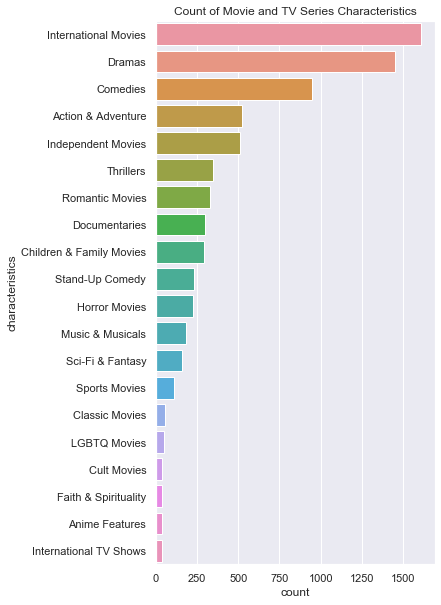

In [16]:
mov_char = ", ".join(netflix_df['listed_in'].fillna("")).split(", ")
movie_characteristics = pd.DataFrame (mov_char, columns=['characteristics'])

char = movie_characteristics.groupby('characteristics')

sns.set(style="darkgrid", palette="pastel", color_codes=True)
plt.figure(figsize=(5,10))
sns.countplot(y='characteristics', data=movie_characteristics, order = movie_characteristics['characteristics'].value_counts().head(20).index)
plt.title('Count of Movie and TV Series Characteristics')
plt.show()

After cleaning the data, the first visualization created depicts the comparison of different characteristics for movies and tv series within the Netflix Library. This visualization shows that Netflix's catalogue of International Movies is greater than any other characteristic trait within the library. This could be due to several reasons such as licensing costs, proprietorship, viewership interests, etc. Additional analysis would be required to understand why Netflix catalogue contains such a large number of International Movies in contrast to having such a small International TV Show catalogue. The second and third highest catalogue of movies are Drama and Comedy. 

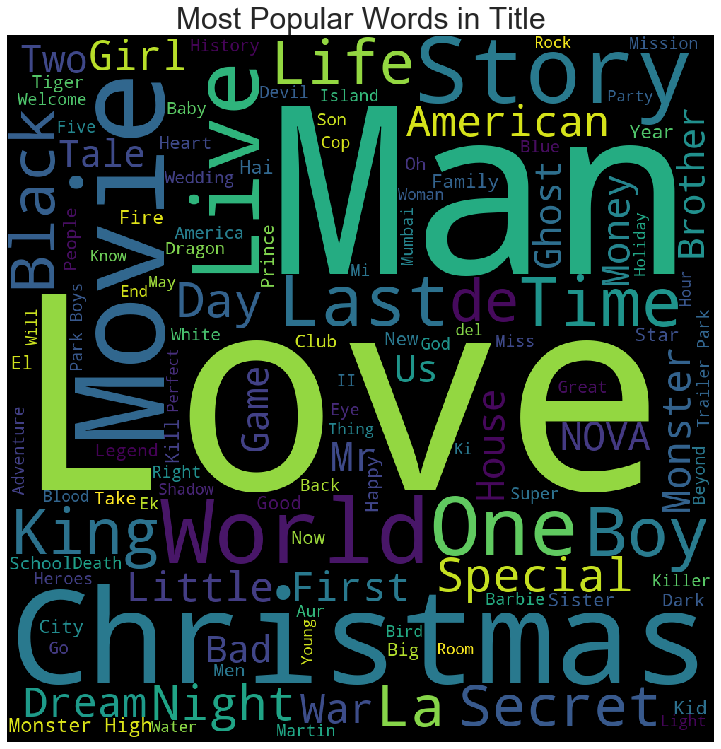

In [179]:
plt.rcParams['figure.figsize'] = (13, 13)
wordcloud = WordCloud(stopwords=STOPWORDS,background_color = 'black', width = 1000,  height = 1000, max_words = 121).generate(' '.join(netflix_df['title']))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Most Popular Words in Title',fontsize = 30)
plt.show()


A visual representation of the most common/populat words to be in a movie title. Love, Christmas, Man, and Movie are considerably the most influential for movie titles. This information couple with the early visualization creates more questions, and opportunities to delve deeper into its content. Primarly, how does International Movies capitalize on titles that involve Christmas in the title? Is Christmas Comedies, or drama's what drives and influences the Netflix Catalogues. Also, Love being the title of a movie alludes to a movie with a drama characteristics, which helps to support the possibility of Love being a popular movie title. 

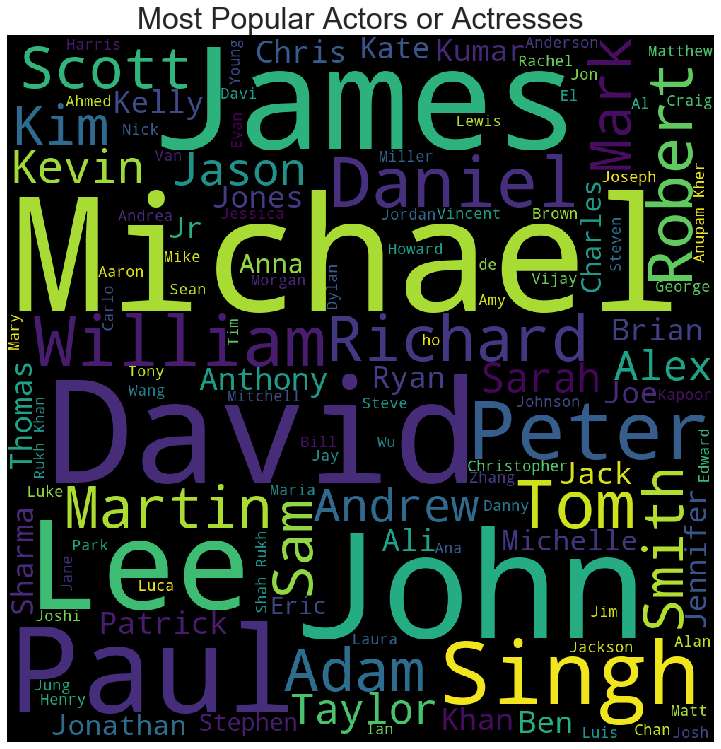

In [180]:
plt.rcParams['figure.figsize'] = (13, 13)
wordcloud = WordCloud(stopwords=STOPWORDS,background_color = 'black', width = 1000,  height = 1000, max_words = 121).generate(' '.join(netflix_df['cast']))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Most Popular Actors or Actresses',fontsize = 30)
plt.show()

A visualization of the most popular actors and actresses names. The majority of names appear to be male which also supports the visualization of popular movie titles; the word "Man" being popularized. There are very few female names demonstrated in the word cloud; also race/ethnicity can't always be inferred from a name, thus any type of speculation surrounding that attribute will be avoided. 

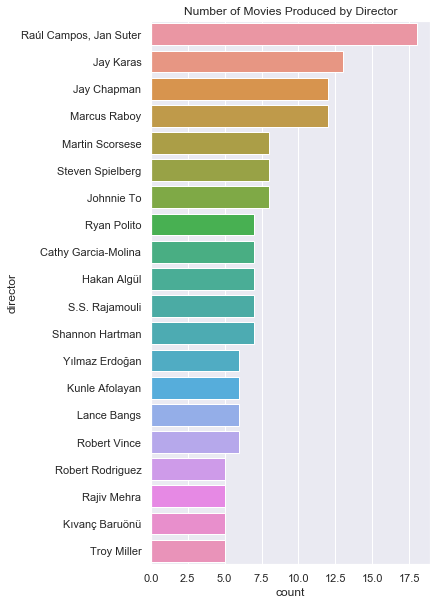

In [181]:
#Bar graph of the number of movies produced by a director in the Netflix Library 

sns.set(style="darkgrid", palette="pastel", color_codes=True)
plt.figure(figsize=(5,10))
sns.countplot(y='director',data=netflix_df,order = netflix_df['director'].value_counts().head(20).index)
plt.title('Number of Movies Produced by Director')
plt.show()

The producer with the highest number of movies in the Netflix Library is Raul Campos, Jan Suter (and through online research) he specializes in Latin America/Spanish comedy. Close to 17 films have been produced by Raul, and with additional research the top three directors specialize in comedy movies/film. 

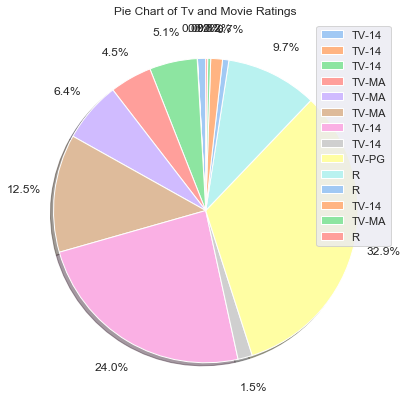

In [182]:
# Breakdown of the movie and tv series rating 

rat=netflix_df.groupby('rating')[['show_id']].count().reset_index()


plt.figure(figsize=(10,7))
plt.pie(rat['show_id'],autopct='%1.1f%%', startangle=90, pctdistance=1.2,shadow=True)
plt.legend(netflix_df['rating'])
plt.title('Pie Chart of Tv and Movie Ratings')
plt.show()

This visualization adds more context to make up up Netflix's catalogue of movies and tv series. TV-14 makes up the largerst percentage for tv series and movies comprising of 32.9% of Netflix's library; TV-MA is the second highest with 24% of the library. This can translate that a large number of of international, drama, and comedy films have TV-MA or TV-14 ratings. This information can be be used to begin addressed the question of movie recommendations. Netflix's catalogue appears to be strong being able to recommned movies that are rated TV-14 or TV-PG for Drama, International, or Comedy, however the reverse is more true with niche movies that include female actressess, in international tv series, with a TV-G rating. 

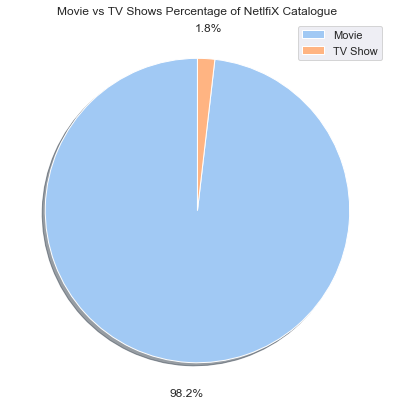

In [183]:
#Generating a pie chart based on the percentage of movies versus TV Shows in the Netflix Catalogue 

type_count = netflix_df.groupby('type')[['show_id']].count().reset_index()

plt.figure(figsize=(10,7))
plt.pie(type_count ['show_id'],autopct='%1.1f%%', startangle=90, pctdistance=1.2,shadow=True)
plt.legend(netflix_df['type'].unique())
plt.title('Movie vs TV Shows Percentage of NetlfiX Catalogue')
plt.show()

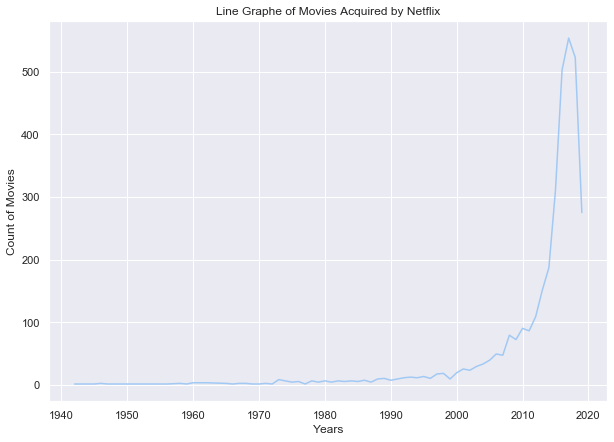

In [184]:
plt.figure(figsize = (10,7))
plt.plot(netflix_df.groupby('release_year')[['type']].count())
plt.xlabel ('Years')
plt.ylabel ('Count of Movies')
plt.title('Line Graphe of Movies Acquired by Netflix')
plt.show()

Between 2010 and 2020 was an aggressive and expansive year for Netflix. This line graphs demonstrates that Netflix more than quadrupled the number of movies in it's catalogue during that decade (more than the previous decade of 2000 - 2010). Howver close to 2020 the number of available movies and tv series decreased; this could be due to the expiration of licenses for several movies, tv series, etc. This can also be coupled with the emergency of competing multiple streaming systems, or Netflix pivoting to invest in in-house development of its tv series and movies. But this information also add's contexts to movie recommendations; there is a limit to the number of viable options within the Netflix network, and that limit has been increasing since 2016. The best time to find a robust library was between 2012 and 2016. 

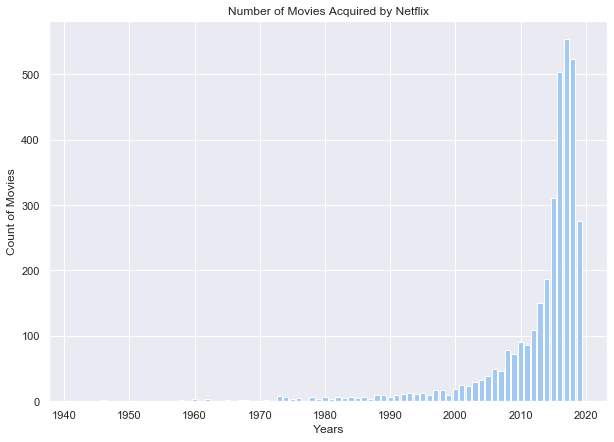

In [185]:
plt.figure(figsize=(10,7))
plt.bar(netflix_df.groupby('release_year')['type'].count().index, netflix_df.groupby('release_year')['type'].count())
plt.xlabel ('Years')
plt.ylabel ('Count of Movies')
plt.title('Number of Movies Acquired by Netflix')
plt.show()

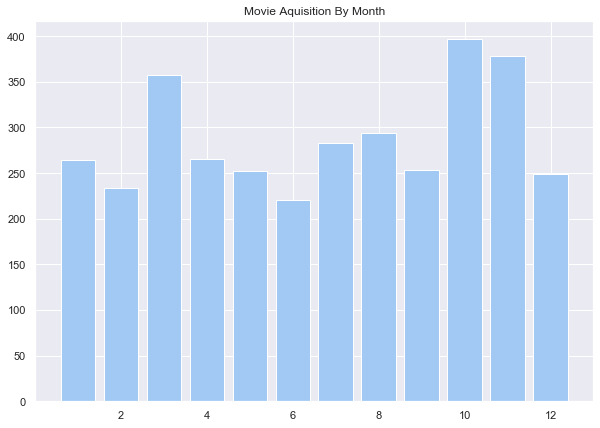

In [186]:
plt.figure(figsize=(10,7))
plt.bar(netflix_df.groupby('month_added')['type'].count().index, netflix_df.groupby('month_added')['type'].count())
plt.title('Movie Aquisition By Month')
plt.show()

October, November, and March are the highest months for movie acquisiton. This may due to the financial calendar. October, November, December, are the begininning on the a new budget year (Quarter 1) which may allow Netflix to invest more in the companies ability to acquire (or in-house produce) movies. 

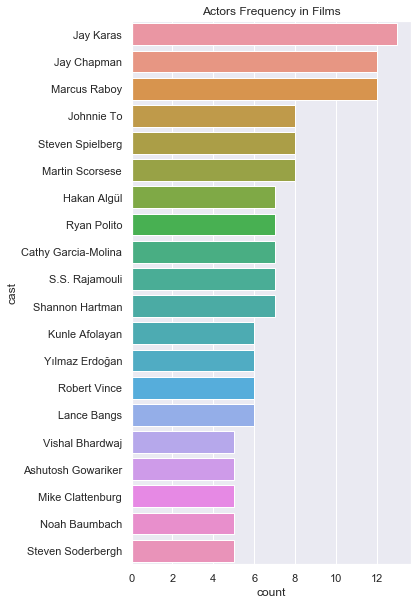

In [187]:
# Get the individual actors for each movie or tv show 
new_cast_df = pd.DataFrame(columns = ['cast','country'])
row = 0 
column = 2

for cast in netflix_df.cast: 
    if ', ' not in  netflix_cast_list[row][column]:
        name_C = netflix_cast_list[row][column]
        country_C =  netflix_cast_list[row][4]
        new_cast_df = new_cast_df.append({'cast': name_C, 'country':country_C}, ignore_index=True)       
    row = row + 1

sns.set(style="darkgrid", palette="pastel", color_codes=True)
plt.figure(figsize=(5,10))
sns.countplot(y='cast',data=new_cast_df,order = new_cast_df['cast'].value_counts().head(20).index)
plt.title('Actors Frequency in Films')
plt.show()


This visualization depicts the the actor/actress most commonly appearing in movies or tv series. Jay Karas appears in 13 films, and Jay Chapman and Mark Rubio appear in 12. The previous data also connected that Jay Karas has produced several comedic movies. 

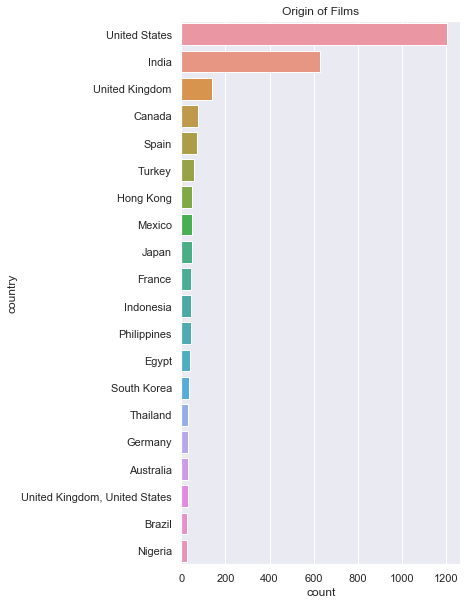

In [188]:
sns.set(style="darkgrid", palette="pastel", color_codes=True)
plt.figure(figsize=(5,10))
sns.countplot(y='country',data=netflix_df,order = netflix_df['country'].value_counts().head(20).index)
plt.title('Origin of Films')
plt.show()

## 5. Dimensionality Reduction 

This section addresses the feature set that's created and eliminating the extraneous information to assess the requirments for a Netflix recommendation system. Two techniques are compared against each other PCA versus t-SNE prior to a cluster algorthim being utilized. 

In [99]:
#Creating dummy variables for disaggregates 
country_dummy = pd.get_dummies(pd.DataFrame([*netflix_df.country], index = netflix_df.country.index).stack()).any(level=0).astype(int)
month_dummy = pd.get_dummies(pd.DataFrame([*netflix_df.month_added], index = netflix_df.month_added.index).stack()).any(level=0).astype(int)
listed_dummies = netflix_df['listed_in'].str.get_dummies(sep=', ')
rating_dummy = pd.get_dummies(pd.DataFrame([*netflix_df.rating], index = netflix_df.rating.index).stack()).any(level=0).astype(int)
year_added_dummy = pd.get_dummies(pd.DataFrame([*netflix_df.year_added], index = netflix_df.year_added.index).stack()).any(level=0).astype(int)


# Instantiate two dataframes; X_df includes the feature set
X_df = pd.DataFrame()
X_two_df = pd.DataFrame()

X_df = pd.concat([X_df, country_dummy], axis=1)
X_df = pd.concat([X_df, month_dummy], axis=1)
X_df = pd.concat([X_df, rating_dummy], axis=1)
X_df = pd.concat([X_df, year_added_dummy], axis=1)
X_df['not_movies'] = pd.get_dummies(netflix_df.type, drop_first=True)
X_df['no_seasons'] = pd.get_dummies(netflix_df.season_count, drop_first=True)

X_two_df = pd.concat([X_two_df, listed_dummies], axis=1)


In [120]:
# Setting the y target to be Thrillers; if a user was requesting Netflix system to recommend a thriller movie
y_reset = pd.DataFrame()
y_reset ['Thrillers'] = X_two_df.Thrillers

#reset index should only be ran once 
y_reset = y_reset.reset_index()

In [121]:
# Don't touch after running the above code; need to reset the index for the DF or else the PCA and tSNE will not run 
y = y_reset.Thrillers

### PCA Dimensionality 

In [126]:
# PCA Dimensionality Technique 
pca = PCA (n_components = 2)
pca_results  = pca.fit_transform(X_df)

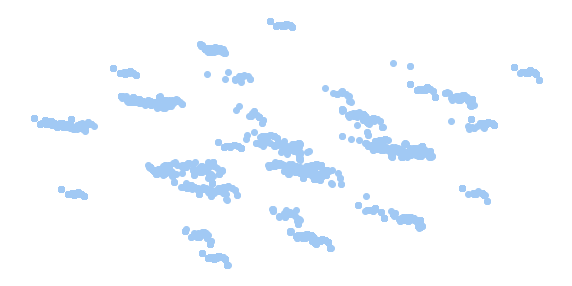

In [128]:
plt.figure(figsize=(10,5))
plt.scatter(pca_results[:, 0], pca_results[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

Via the monochromatic and polychromatic visualization, different possible centroids for the data. PCA dimensionality appears to be the best technique for representing the Netflix data, possible linearity relationship, and the dissimilarities in the data. We can begin to infer the differnt classes through the visualization in both graphs, with some crossover between several classes. Further evaluation of another dimensionality technique will be able to confirm if PCA is the best technique.  

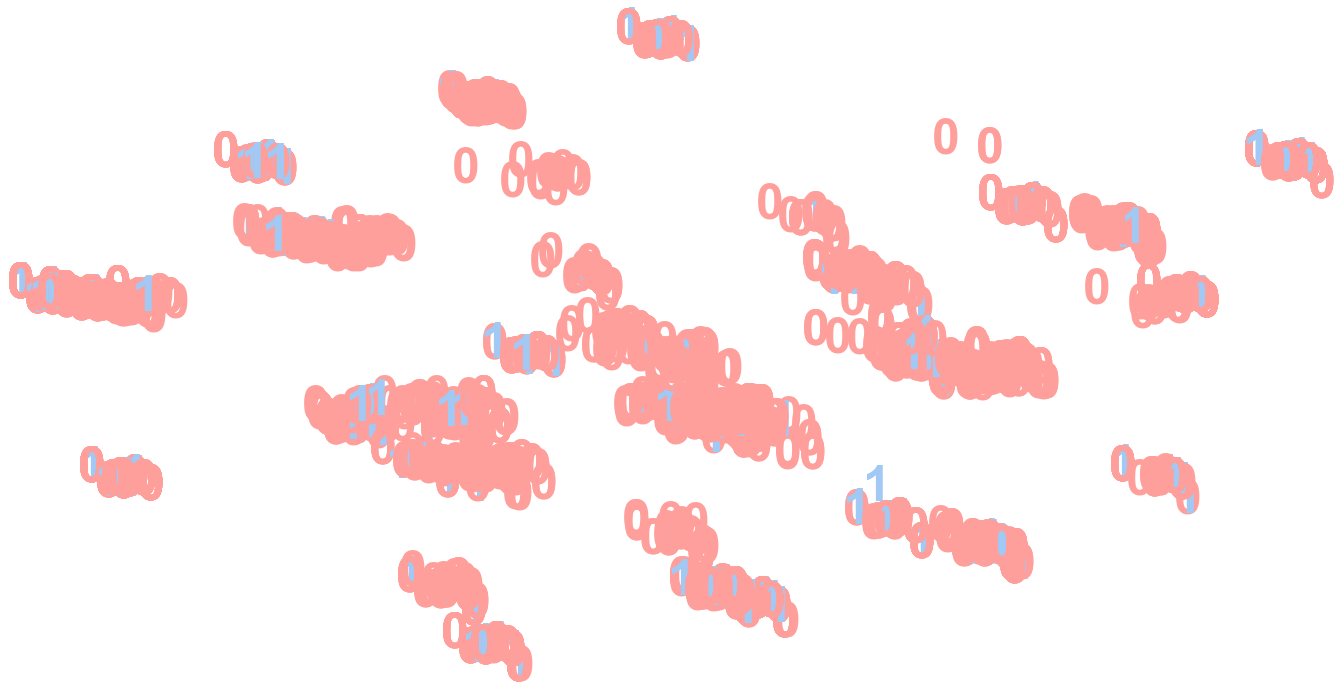

In [131]:
#Colorized PCA 
plt.figure(figsize=(10,5))
colours = ["r","b","g","c","m","y","k","r","burlywood","chartreuse"]

for i in range(pca_results.shape[0]):
    plt.text(pca_results[i, 0], pca_results[i, 1], str(y[i]),
             color=colours[int(y[i])],
             fontdict={'weight': 'bold', 'size': 50}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

### t-SNE Dimensionality 

In [127]:
# Compairing dimensionality Technique against PCA 

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_result = tsne.fit_transform(X_df)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3447 samples in 0.491s...
[t-SNE] Computed neighbors for 3447 samples in 9.414s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3447
[t-SNE] Computed conditional probabilities for sample 2000 / 3447
[t-SNE] Computed conditional probabilities for sample 3000 / 3447
[t-SNE] Computed conditional probabilities for sample 3447 / 3447
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.962814
[t-SNE] KL divergence after 300 iterations: 1.627041


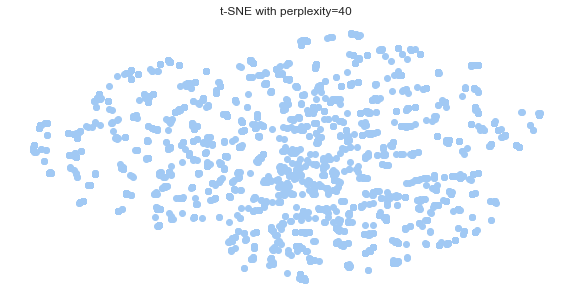

In [130]:
plt.figure(figsize=(10,5))
plt.title("t-SNE with perplexity=40")
plt.scatter(tsne_result[:, 0], tsne_result[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

The tSNE algorithm is not the best tool to be used for dimensionality reduction. The primary reasons is that each feature is weighted equally causing the visualization to show an very expanded view os possible cluster sizes. Thus signify that the data points are denser. Originally it might be expected that tSNE would perform better because it is better equipped to highlight non linear relationships as well depict dissimilarities better than PCA. However, via the visualization of both monochrome and the polychromatic graph, it is difficult to different potential clusters or data points centroids. This alludes to the possibility of the data have linerarity.   

In [123]:
#Colorized tSNE 

plt.figure(figsize=(10,5))
colours = ["r","b","g","c","m","y","k","r","burlywood","chartreuse"]

for i in range(tsne_result.shape[0]):
    plt.text(tsne_result[i, 0], tsne_result[i, 1], y[i],
             color=colours[int(y[i])],
             fontdict={'weight': 'bold', 'size': 50}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

## 6. Clustering & Evaluation 

### KMeans

In [158]:
# Crosstabs of K-Means using PCA DataFrame 
kmeans_pred = KMeans(n_clusters=2, random_state=123).fit_predict(pca_results)
pd.crosstab(y,kmeans_pred)

col_0,0,1
Thrillers,,
0,1303,1796
1,154,194


Based on the crosstab, the data isn't perfectly being clustered. Thus, re-evaluating the number of components in PCA and kmeans clustering can influence the clustering of data. 

In [159]:
#Check the silhoue tte and the ARI 
print("Silhouette score for three cluster k-means: {}".format(metrics.silhouette_score(pca_results, kmeans_pred, metric='euclidean')))
print("ARI for three cluster k-means: {}".format(metrics.adjusted_rand_score(y, kmeans_pred)))

Silhouette score for three cluster k-means: 0.40460774930734933
ARI for three cluster k-means: 0.0019692414492368374


The ARI being in the negative can insinuate that the clustering solution is close to random. The Silhouette number is show's an almost 44% percent similarity between the PCA results 

### Agglomerative

In [153]:
#Agglomerative Ward 
agg_cluster = AgglomerativeClustering(linkage='ward', affinity='euclidean', n_clusters=2 )
clusters = agg_cluster.fit_predict(pca_results)

The reason Ward method is used is because we're looking for similarities in movies based on specific features. The Ward method looks clusters that are similar and dissimilar from other clusters via euclidean distance. 

In [160]:
#Crosstabs of Agglomerative Cluster
clusters = np.array([0 if x == 1 else 1 if x==0 else 2 for x in clusters])
pd.crosstab(y,clusters)

col_0,0,1
Thrillers,,
0,771,2328
1,91,257


In [148]:
#Check the silhoue tte and the ARI 
print("Silhouette score for two cluster k-means: {}".format(metrics.silhouette_score(pca_results, clusters, metric='euclidean')))
print("ARI for two cluster k-means: {}".format(metrics.adjusted_rand_score(y, clusters)))

Silhouette score for two cluster k-means: 0.46992922884836824
ARI for two cluster k-means: -0.0018570792477166581


The crosstab for Agglomerative doesn't perfectly cluster all of the data points for the two component analysis. The Agglomerative approach is better than the KMeans testing and produces a higher silhouette score. The Rand score can be improved by improving on the model originally selected.

### Dendrogram 

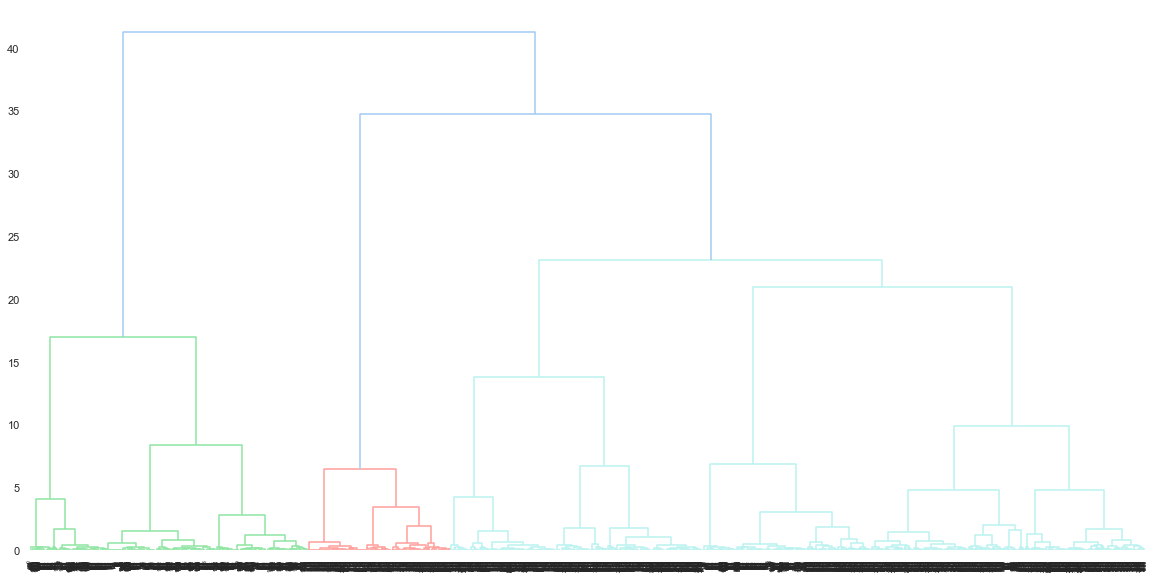

In [162]:
#Dendrogram  Ward 
plt.figure(figsize=(20,10))
dendrogram(linkage(pca_results, method='ward'))
plt.show()

## 7. Summary

### Quantifiable Results 

The data set was able to provide a lot of information regarding the Netflix library, including the types of movie that comprised of Netflix's library, popular actors and actresses, rate of movies produced by region, etc. Netflix has acquired an exceptionally large category of international movies, close to 1700, some of which date as far back as 1960. The second highest characteristic trait of Netflix category is drama movies, with "Love" being a popular word in movie titles, as well as "Christmas". 

Conversely more male actors are favored in the Netflix library compared to women in movies and tv series. The data was also able to show that Netflix doesn't have a large category of international tv series, and that the United States had the highest production, 1200 movies, with India being the second highest (a little over 600 movies). One of the most interesting facets of the data is being able to see the acquisition of movies by Netflix; how their acquistion peaked in 2012 but is continually declining. It can be speculated that the reason for this is due to the emergence of other streaming services, cost of movie licenses, business practices, as well as moving to a business model of movie/tv series production, versus owner/rentership. 

When synthesizing the data and taking different clustering approaches it became clear that clustering can be leverage to identify similar movies based on the movie characteristics. Agglomerative Analysis was able to show clear clustering of the data, when only prioritize two components such as the country of release and the movie rating albiet perfectly. However the silhoutte score provided was .47 and can notably be improved upon by either evaluating the number of components or pca dimensionality. Also, by evaluating different cluster techniques such as the dendogram we were able to visually see that an increase in the number of components would most likely results in better centralization of the data. The clustering approach utilized was geared towards being able to find similar movies for Thriller; by looking at several features and evaluating their variances, clustering appears to be a better approach than classification for movie similarity analysis. 

### Next Steps

The next steps would include building a program that could recommend similar movies based on a suggestion. Then using supervised data to create a training and test set that this model will be able to be tested against and fine tune. 

### Shortcomings 

The initial shortcomings began with the data set. The data set was missing information; a little over 30% of the director data was missing. This information can greatly skew the recommendation process, because through the exploratory phase of the data we saw how the number one director was also a high flavored actor. The trait could've influence the clustering of data, as well as play a  role when creating a recommendation model. The data set didn't have information related to the production cost of movies, or the amount of viewership. Being able to combine some level of supervised data would strength the ability to create an effective movie suggestion model. Lastly, another short coming of the clusting approach was the required volume of data. Unfortunately when trying to evaluate a model based on the combination of certain actors and directors was to labor intensive on the system.

# Thank You 